# Amirhossein Rostami - 2084299 
# Abbas Zal - 2072054

### Human Data Analytics Course 2024 

In [1]:
#Importing Libraries 

from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten, Dropout
import pandas as pd
import tensorflow as tf
import numpy as np
import time
import os
import zipfile
from scipy.signal import medfilt

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve,classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from collections import Counter

import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc, precision_recall_curve, average_precision_score, precision_recall_curve, average_precision_score, precision_score, recall_score,f1_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import plot_model
import visualkeras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns 


In [58]:
df = pd.read_csv('norm_data.csv') # reading the amplitude signals dataset


In [31]:
signals_list = [ 'lh_r','lw_r', 'la_r', 'ra_r']

# Function to create windows from the dataset

def create_windows(df, window, step, signal):
    windows = []
    labels = []

    start = 0
    end = len(df)

    while start + window <= end:
        window_df = df.iloc[start:start + window]
        
        #  if all activity values in the window are the same
        if window_df['activity'].nunique() == 1:
            # Checking the time values in the window
            starting_time = window_df['time_s'].iloc[0]
            expected_end_time = starting_time + (window * 0.01)
            actual_end_time = window_df['time_s'].iloc[-1]
            
            if np.isclose(actual_end_time, expected_end_time, atol=1e-2):
                window_signal = window_df[signal].values
                windows.append(window_signal)
                labels.append(window_df['activity'].iloc[0])
        
        start += step
        
    return np.array(windows), np.array(labels)


In [42]:
# Baseline wander removal function
def baseline_wander_removal(data):
    # Sampling frequency
    fs = 100  # sampling frequency 
    # Baseline estimation
    win_size = int(np.round(0.2 * fs)) + 1
    baseline = medfilt(data, win_size)

    win_size = int(np.round(0.6 * fs)) + 1
    baseline = medfilt(baseline, win_size)

    # Removing baseline
    filt_data = data - baseline
    return filt_data

#steps to apply baseline wander removal and normalization of the singals 
signal_columns = ['lw_r', 'lh_r', 'la_r', 'ra_r']
filtered_signals = {col: baseline_wander_removal(df[col].values) for col in signal_columns}
df_removal = pd.DataFrame(filtered_signals)
df_removal['activity'] = df['activity']
df_removal['time_s'] = df['time_s']

df_removal = df_removal[['time_s', 'activity'] + signal_columns]

def normalize_data(data):
    # Amplitude estimate
    norm_factor = np.percentile(data, 99) - np.percentile(data, 5)
    return (data / norm_factor)

normalized_signals = {col: normalize_data(df_removal[col].values) for col in signal_columns}


df_normalized = pd.DataFrame(normalized_signals)


df_normalized['activity'] = df_removal['activity']
df_normalized['time_s'] = df_removal['time_s']


df_normalized = df_normalized[['time_s', 'activity'] + signal_columns]


In [60]:

def label_count(label): # Function for counting the number of lables at the dataframe 
    label_counts = Counter(label)
    print("Label counts using Counter:")
    for label, count in label_counts.items():
        print(f'Label: {label}, Count: {count}')

Genral functions 

In [61]:

def prep(df,window_size=256,step=256, signal=signals_list ,test_size=0.3): # Function to prepare data for training, 

    
    windows, labels = create_windows(df, window=window_size, step=step, signal=signal)
    label_count(labels)
    # plot_label_counts(labels)
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_encoded), y=labels_encoded) # class weights used for imbalance data 
    class_weights_dict = dict(enumerate(class_weights))

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        windows, labels_encoded, test_size=test_size, stratify=labels_encoded, random_state=123
    )

    train_class_distribution = {label: count for label, count in zip(*np.unique(y_train, return_counts=True))}
    test_class_distribution = {label: count for label, count in zip(*np.unique(y_test, return_counts=True))}

    print("Train class distribution:", train_class_distribution)
    print("Test class distribution:", test_class_distribution)
    # Reshape data for CNN input

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 4)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 4)

    # Print shapes for verification
    print(f'X_train shape: {X_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'y_test shape: {y_test.shape}')



    return X_train, X_test, y_train, y_test,class_weights_dict

class_names = ['1-walking', '2-desc stairs', '3-asce stairs']

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_prc(y_true, y_pred_probs, class_names):
    
    y_true_binarized = label_binarize(y_true, classes=np.arange(len(class_names)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 5))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        average_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred_probs[:, i])

    plt.figure(figsize=(8, 5))
    for i in range(len(class_names)):
        plt.plot(recall[i], precision[i], label=f'{class_names[i]} (average precision = {average_precision[i]:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

In [62]:
def build_model(input_size, num_classes): # CNN mode builder , we use input shape (window_size, 4) because we use all signals as input 
    input_shape = (input_size,4)

    
    model = Sequential()
    
    # CNN part
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    
    # GRU part
    model.add(GRU(128, return_sequences=True))
    model.add(GRU(128))
    
    # Fully connected part
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [63]:
def results(df,window_size,step_size,signal2,epoch = 30,batch_size =64): # Fnction for training and evaluating the model 
    
    X_train, X_test, y_train, y_test,class_weights_dict =prep(df=df,window_size=window_size,step=step_size,signal=signal2)
    
    model = build_model(input_size=window_size,num_classes=3)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.2,patience=5,verbose=1, mode='auto',min_lr=1e-5)


    history = model.fit(X_train, y_train, validation_split=0.2, epochs=epoch, batch_size=batch_size, 
                         class_weight=class_weights_dict, callbacks=[reduce_lr])
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    plot_training_history(history)
    plot_roc_prc(y_test, y_pred_probs, class_names)
    final_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    final_precision = precision_score(y_test, y_pred, average='weighted')
    final_recall = recall_score(y_test, y_pred, average='weighted')
    final_f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'Final Accuracy: {final_accuracy}')
    print(f'Final Precision: {final_precision}')
    print(f'Final Recall: {final_recall}')
    print(f'Final F1 Score: {final_f1}')
    plot_confusion_matrix(y_test, y_pred, class_names)
    
    return history

# Window Size 256 , Step Size 256

Label counts using Counter:
Label: 1, Count: 5923
Label: 2, Count: 839
Label: 3, Count: 876
Train class distribution: {0: 4146, 1: 587, 2: 613}
Test class distribution: {0: 1777, 1: 252, 2: 263}
X_train shape: (5346, 256, 4)
X_test shape: (2292, 256, 4)
y_train shape: (5346,)
y_test shape: (2292,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 254, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 127, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 62, 128)          0         
 1D)                 

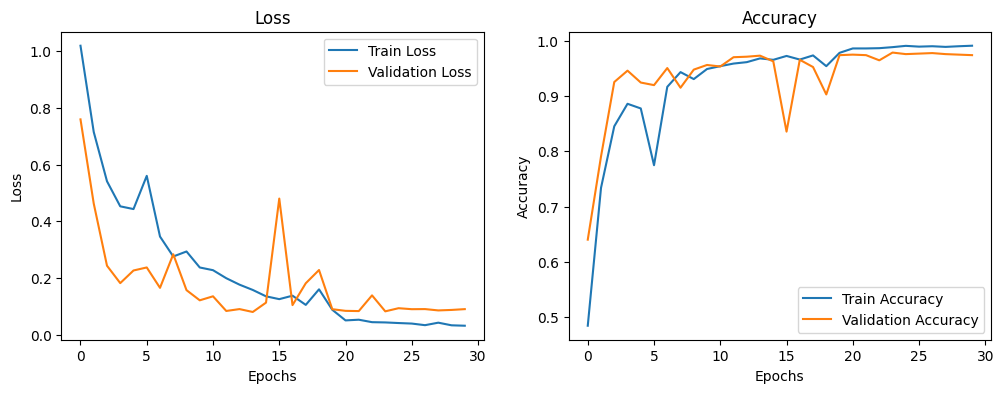

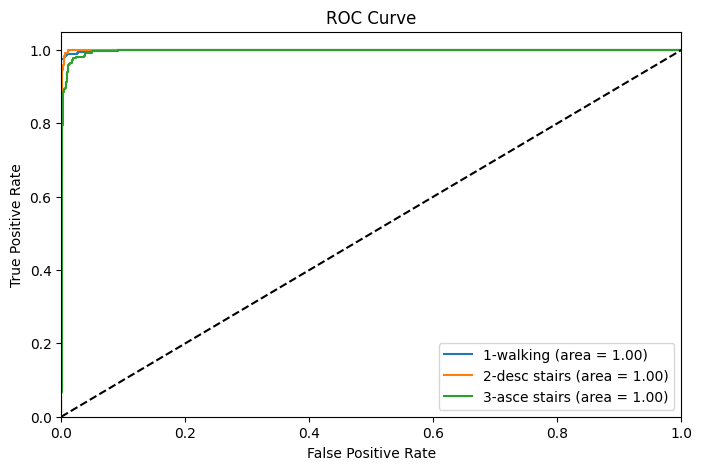

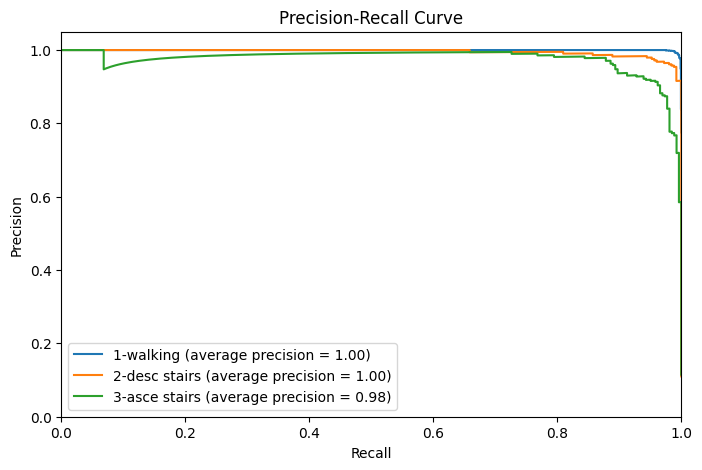

Final Accuracy: 0.9825479984283447
Final Precision: 0.9830255079693132
Final Recall: 0.9825479930191972
Final F1 Score: 0.9827024598500738


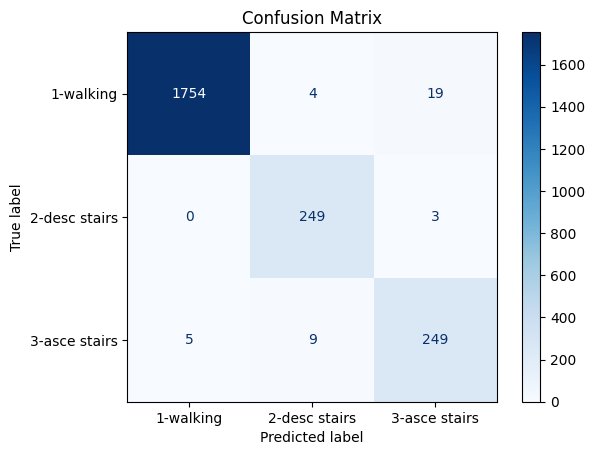

In [49]:
history_257 = results(df=df_normalized,window_size=256,step_size=256,signal2=signals_list,epoch=30,batch_size=32)

# window Size 512, step size 512

Label counts using Counter:
Label: 1, Count: 2894
Label: 2, Count: 323
Label: 3, Count: 348
Train class distribution: {0: 2025, 1: 226, 2: 244}
Test class distribution: {0: 869, 1: 97, 2: 104}
X_train shape: (2495, 512, 4)
X_test shape: (1070, 512, 4)
y_train shape: (2495,)
y_test shape: (1070,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 510, 64)           832       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 255, 64)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 253, 128)          24704     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 126, 128)         0         
 1D)                 

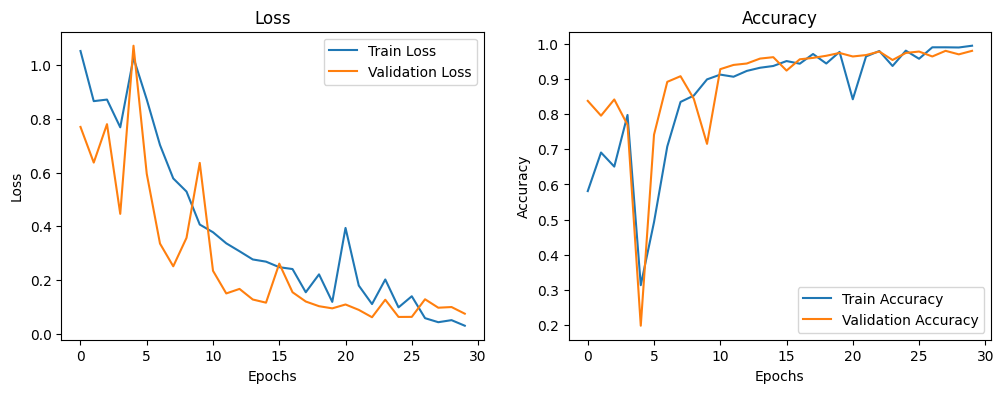

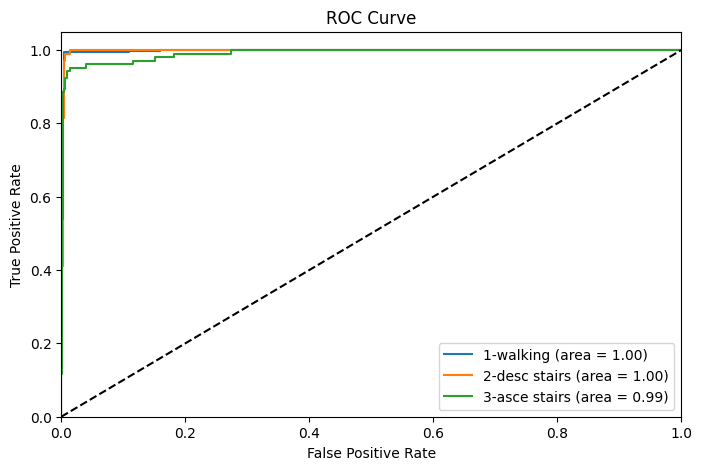

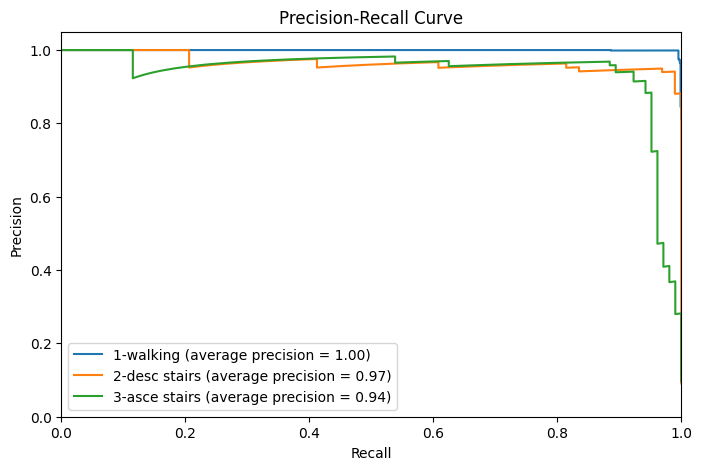

Final Accuracy: 0.9850467443466187
Final Precision: 0.9855156162868178
Final Recall: 0.9850467289719627
Final F1 Score: 0.9851197809426464


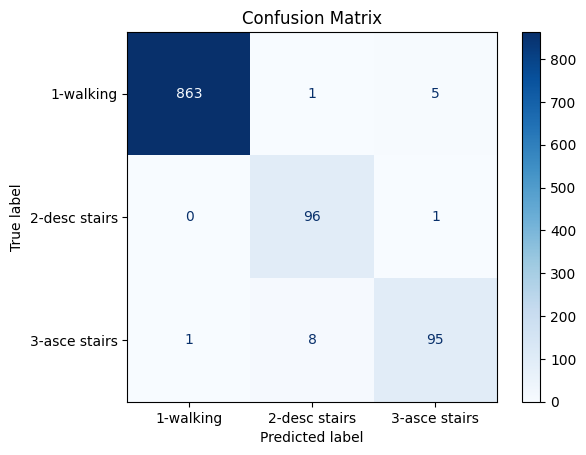

In [51]:
history_512 = results(df=df_normalized,window_size=512,step_size=512,signal2=signals_list,epoch=30,batch_size=32)

Label counts using Counter:
Label: 1, Count: 5536
Label: 2, Count: 272
Label: 3, Count: 309
Train class distribution: {0: 3875, 1: 190, 2: 216}
Test class distribution: {0: 1661, 1: 82, 2: 93}
X_train shape: (4281, 1024, 4)
X_test shape: (1836, 1024, 4)
y_train shape: (4281,)
y_test shape: (1836,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1022, 64)          832       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 511, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 509, 128)          24704     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 254, 128)         0         
 1D)               

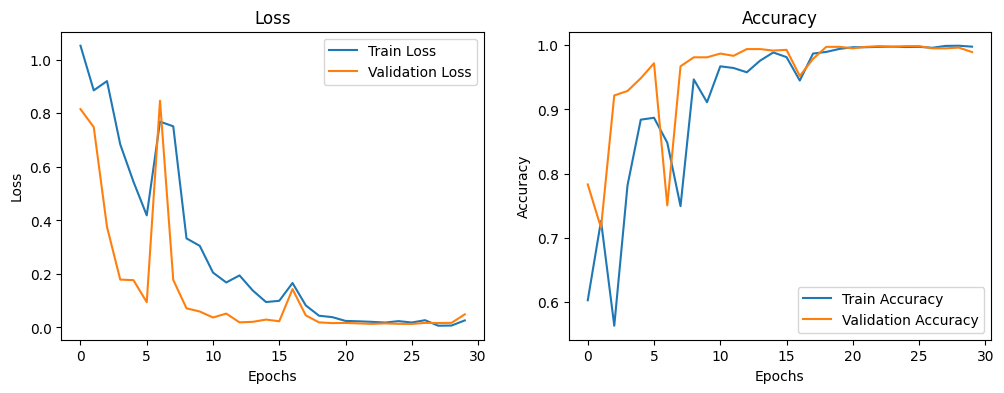

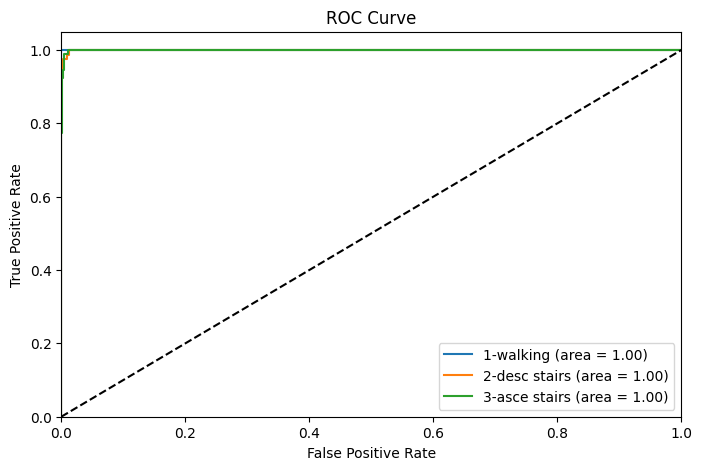

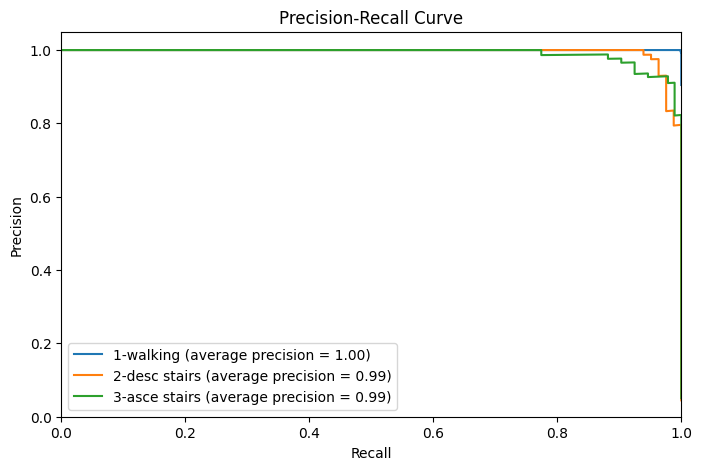

Final Accuracy: 0.9896514415740967
Final Precision: 0.9912301750537045
Final Recall: 0.9896514161220044
Final F1 Score: 0.989730963370721


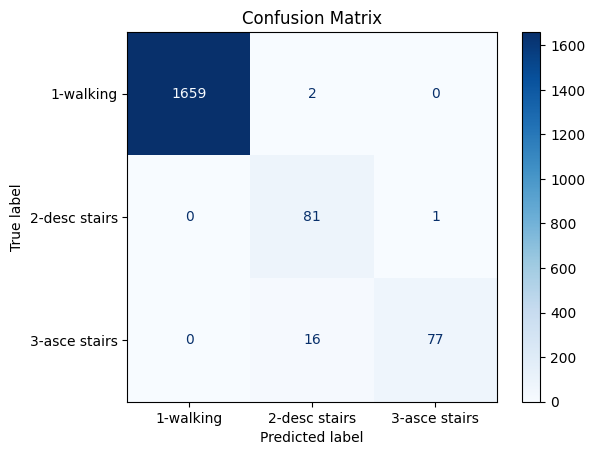

In [52]:
history_1024 = results(df=df_normalized,window_size=1024,step_size=256,signal2=signals_list,epoch=30,batch_size=32)